# Project LFR Graph Generation and Evaluation
#### 2021

This notebook combines all important functions and results which accumulated over the time of this project.

### Main topics
* Graph Generation<br>
Efficiently generate single or mixed graphs with certain graph and feature attributes using LFR.

* Graph Evaluation<br>
Compute statistics on graphs, including training and evaluation of several GNN and MLP models.

* Sensitive Feature evaluation<br>
Construct graphs with a sensitive feature, which is dependent on the graph structure, and compare its influence on GNN and MLP models.

In [1]:
# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-geometric

import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from IPython.display import display
from lfr_graph_generator.graph_generation import *
from lfr_graph_generator.utils import *
from torch_geometric.datasets import Actor, Planetoid, WebKB, WikipediaNetwork
from tqdm import tqdm
from scipy.stats import chi2_contingency

torch.set_num_threads(1) # necessary for multiprocessing

np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


# Graph Generation



##### Problem 
LFR often does not find a working graph with parameters

##### Solution
Execute graph search in parallel and also return the seed of found solution for later usage

##### Example below
3 different seeds for the same parameters

In [4]:
res = []
for i in tqdm(range(3)):
    data, seed = search_graph_parallel(
        n=2708, 
        mu=0.2,
        avg_degree=4
    )

    eval_res = eval_data(data, evaluate_models=False)
    eval_res["seed"] = seed

    res.append(eval_res)

pd.DataFrame(res, index=[f"Iteration {i} Graph" for i in range(3)]).T

100%|██████████| 3/3 [00:30<00:00, 10.31s/it]


,Iteration 0 Graph,Iteration 1 Graph,Iteration 2 Graph
Number of edges,5719,6009,5723
Number of nodes,2708,2708,2708
Number of features,5,5,5
Homophily edge ratio,0.8,0.79,0.79
Homophily 1-hop,0.82,0.81,0.81
Homophily 2-hop,0.62,0.61,0.61
RMI,0.73,0.7,0.72
Degree power law exponent,2.7,2.59,2.66
Average degree,4.22,4.44,4.23
Number of different labels (y),17,20,17


### Generate Graphs with similar structure to selected popular graph datasets

##### Cora

In [3]:
cora_data = Planetoid(root='/tmp/Cora', name='Cora')[0]

LFR_data = generate_LFR_graph( 
    n=2708, 
    mu=0.2,
    avg_degree=4, 
    seed=138
)

pd.DataFrame(
    [eval_data(cora_data, evaluate_models=False), eval_data(LFR_data, evaluate_models=False)], 
    index=["Original Cora", "LFR Cora"]
).T

Processing...
Done!


,Original Cora,LFR Cora
Number of edges,5355,5659
Number of nodes,2708,2708
Number of features,1433,5
Homophily edge ratio,0.8,0.8
Homophily 1-hop,0.81,0.81
Homophily 2-hop,0.69,0.6
RMI,0.62,0.74
Degree power law exponent,1.91,2.65
Average degree,3.95,4.18
Number of different labels (y),7,24


##### Pubmed

In [4]:
pubmed_data = Planetoid(root= '/tmp/pubmed', name ='pubmed')[0]

found_data = generate_LFR_graph( 
    n=19717, 
    mu=0.2,
    min_community_size=1000, # gives fewer but larger communitites
    avg_degree=4, 
    seed=911
)

pd.DataFrame(
    [eval_data(pubmed_data, evaluate_models=False), eval_data(found_data, evaluate_models=False)], 
    index=["Original pubmed", "LFR pubmed"]
).T

Processing...
Done!


,Original pubmed,LFR pubmed
Number of edges,44324,43188
Number of nodes,19717,19717
Number of features,500,5
Homophily edge ratio,0.8,0.79
Homophily 1-hop,0.79,0.8
Homophily 2-hop,0.74,0.62
RMI,0.39,0.55
Degree power law exponent,2.18,2.63
Average degree,4.5,4.38
Number of different labels (y),3,16


##### Chameleon (as mixture of several sub-graphs)

In [5]:
chameleon_data = WikipediaNetwork(root='/tmp/chameleon', name='chameleon')[0]

found_data = generate_mixed_graph( 
    n=2277, 
    mus=[0.4, 0.4],
    avg_degrees=[13, 13],
    seeds=[869, 372]
)

pd.DataFrame(
    [eval_data(chameleon_data, evaluate_models=False), eval_data(found_data[0], evaluate_models=False)], 
    index=["Original chameleon", "LFR chameleon"]
).T

Processing...
Done!
2it [00:01,  1.61it/s]


,Original chameleon,LFR chameleon
Number of edges,31421,33298
Number of nodes,2277,2277
Number of features,2325,10
Homophily edge ratio,0.23,0.27
Homophily 1-hop,0.25,0.26
Homophily 2-hop,0.25,0.11
RMI,0.13,0.22
Degree power law exponent,1.39,2.26
Average degree,27.6,29.25
Number of different labels (y),5,13


# Evaluation with GNNs and MLP
The models are trained on a train set and a validation set is used for early stopping. The trained model is then evaluated on a test set, which gives the presented accuracies.

In [6]:
cora_data = Planetoid(root='/tmp/Cora', name='Cora')[0]

LFR_data = generate_LFR_graph( 
    n=2708, 
    mu=0.2,
    avg_degree=4, 
    seed=138
)

pd.DataFrame(
    [eval_data(cora_data, evaluate_models=True), eval_data(LFR_data, evaluate_models=True)], 
    index=["Original Cora", "LFR Cora"]
).T

,Original Cora,LFR Cora
GCN Acc,0.793,0.6795
GAT Acc,0.792,0.7031
GraphSAGE Acc,0.804,0.6987
SGC Acc,0.785,0.7134
H2GCN Acc,0.814,0.4756
MLP Acc,0.554,0.4136
Number of edges,5355,5659
Number of nodes,2708,2708
Number of features,1433,5
Homophily edge ratio,0.8,0.8


### Control performance of GNNs using mu parameter (mixing parameter)
mu = 1 - edge-homophily-ratio

MLP performance stays constant, GNNs performance increase with higher homophily.

100%|██████████| 5/5 [04:17<00:00, 51.42s/it]


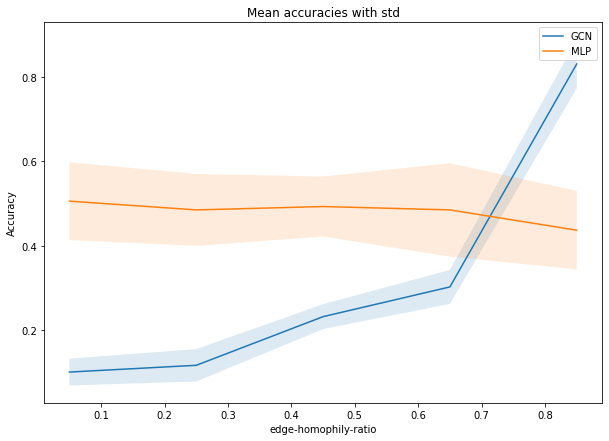

In [7]:
mu_values = np.arange(0.15, 1, 0.2)[::-1]

gcn_means = np.zeros(len(mu_values))
mlp_means = np.zeros(len(mu_values))
gcn_stds = np.zeros(len(mu_values))
mlp_stds = np.zeros(len(mu_values))

for i, mu in tqdm(enumerate(mu_values), total=len(mu_values)):

    gcn_accs = []
    mlp_accs = []

    for _ in range(5):
        LFR_data, _ = search_graph_parallel(
            n=500, 
            mu=mu, 
            avg_degree=5, 
            min_community_size=15
        )

        LFR_res = eval_data(LFR_data)

        gcn_accs.append(LFR_res["GCN Acc"])
        mlp_accs.append(LFR_res["MLP Acc"])

    gcn_means[i] = np.mean(gcn_accs)
    gcn_stds[i] = np.std(gcn_accs)

    mlp_means[i] = np.mean(mlp_accs)
    mlp_stds[i] = np.std(mlp_accs)

edge_hom_ratio = 1 - mu_values

plt.figure(figsize=(10,7))
plt.plot(edge_hom_ratio, gcn_means, label="GCN")
plt.fill_between(edge_hom_ratio, gcn_means-gcn_stds, gcn_means+gcn_stds, alpha=0.15)

plt.plot(edge_hom_ratio, mlp_means, label="MLP")
plt.fill_between(edge_hom_ratio, mlp_means-mlp_stds, mlp_means+mlp_stds, alpha=0.15)

plt.xlabel(r"edge-homophily-ratio")
plt.ylabel("Accuracy")
plt.title("Mean accuracies with std")
plt.legend()
plt.show()

### Control the overall performance by changing the variance of the feature gaussian
MLP performance decreases strongly, while GNNs decrease gradually

100%|██████████| 16/16 [13:33<00:00, 50.83s/it]


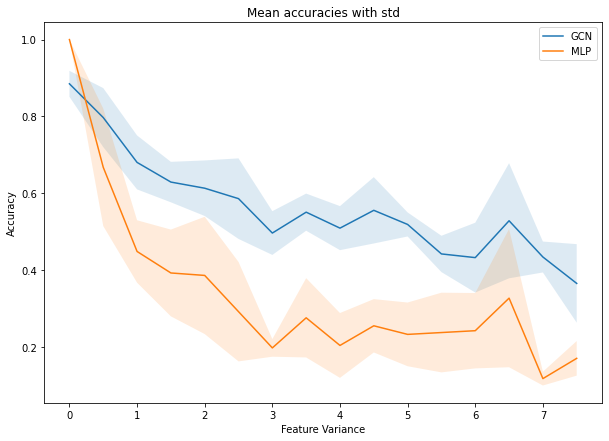

In [8]:
feature_variances = np.arange(0, 8, 0.5)

gcn_means = np.zeros(len(feature_variances))
mlp_means = np.zeros(len(feature_variances))
gcn_stds = np.zeros(len(feature_variances))
mlp_stds = np.zeros(len(feature_variances))

for i, feature_variance in tqdm(enumerate(feature_variances), total=len(feature_variances)):

    gcn_accs = []
    mlp_accs = []

    for _ in range(5):
        LFR_data, _ = search_graph_parallel(
            n=500, 
            mu=0.2, 
            avg_degree=5, 
            min_community_size=15, 
            feature_cov=feature_variance
        )

        LFR_res = eval_data(LFR_data)

        gcn_accs.append(LFR_res["GCN Acc"])
        mlp_accs.append(LFR_res["MLP Acc"])

    gcn_means[i] = np.mean(gcn_accs)
    gcn_stds[i] = np.std(gcn_accs)

    mlp_means[i] = np.mean(mlp_accs)
    mlp_stds[i] = np.std(mlp_accs)

plt.figure(figsize=(10,7))
plt.plot(feature_variances, gcn_means, label="GCN")
plt.fill_between(feature_variances, gcn_means-gcn_stds, gcn_means+gcn_stds, alpha=0.15)

plt.plot(feature_variances, mlp_means, label="MLP")
plt.fill_between(feature_variances, mlp_means-mlp_stds, mlp_means+mlp_stds, alpha=0.15)

plt.xlabel(r"Feature Variance")
plt.ylabel("Accuracy")
plt.title("Mean accuracies with std")
plt.legend()
plt.show()

# Generating graphs with a sensitive feature

Goal: Add a binary sensitive feature to each node, which should be independent of the label, but not of the community.

Basic Approach:


1.   Generate LFR Graph. The communities found by the louvaine-algorithm are now called sub-communities
2.   A sensitive binary feature is added to each node in a controlled fashion. Each sub-community 
has a probability which controls if the sensitive feature of the communities nodes is True (= 1). These probabilites are sampled from a uniform distribution between [0, 1].
3.   The sub-communities are combined to label-communities, which will be used as the target label when evaluating the ML models. The merging is done by combining the pair of sub-communities which maximize the modularity. The number of label-communities should be quite smaller than the number of node-communities.
4.   For comparison, another graph with the sensitive feature is generated, where the sensitive feature is sampled randomly (zodiac sign feature).

For the controlled feature this should result in each sub-communities having a 
different distribution, while the
label-communities should be closer to a random distribution, as the sub-communities are merged together (with some 
variability).

### Small conceptual example of sub- and label-communities



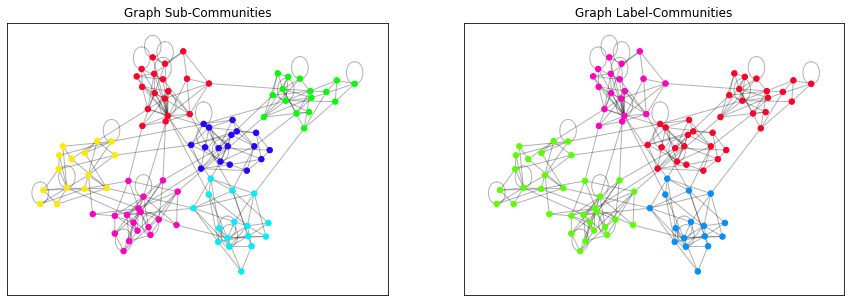

In [9]:
found_data = generate_LFR_graph( 
    n=100, 
    mu=0.1,
    avg_degree=6, 
    min_community_size=15,
    seed=983
)

reduced_found_data, reduced_data_sensitive_controlled, reduced_data_sensitive_random, label_df = combine_subcommunities(found_data, num_comms=4)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
plot_nxgraph(data_to_nx(found_data), ax=axs[0], name="Sub-Communities")
plot_nxgraph(data_to_nx(reduced_data_sensitive_controlled), ax=axs[1], name="Label-Communities")

### Cora Example
Number of edges and nodes stays the same for all graphs.

In [21]:
found_data = generate_LFR_graph( 
    n=2708, 
    mu=0.2,
    avg_degree=4, 
    seed=138
)

cora_number_of_labels = 7

reduced_found_data, reduced_data_sensitive_controlled, reduced_data_sensitive_random, label_df = combine_subcommunities(found_data, num_comms=cora_number_of_labels)

pd.DataFrame([
    eval_data(found_data, evaluate_models=False), 
    eval_data(reduced_data_sensitive_controlled, evaluate_models=False),
    eval_data(reduced_data_sensitive_random, evaluate_models=False),
    ], index=["LFR Cora", "LFR Cora - sensitive controlled", "LFR Cora - sensitive random"]
).T

,LFR Cora,LFR Cora - sensitive controlled,LFR Cora - sensitive random
Number of edges,5659,5659,5659
Number of nodes,2708,2708,2708
Number of features,5,6,6
Homophily edge ratio,0.8,0.8,0.8
Homophily 1-hop,0.81,0.82,0.82
Homophily 2-hop,0.6,0.62,0.62
RMI,0.74,0.67,0.64
Degree power law exponent,2.65,2.65,2.65
Average degree,4.18,4.18,4.18
Number of different labels (y),24,7,7


The means of the controlled feature for each sub-communities form a uniform distribution over [0,1], while the label-community means are all around 0.5.

For the zodiac sign feature the means of the sub-communities and label-communities are all close to 0.5, as each node has a probability of 0.5 of the feature to be True (or 1).

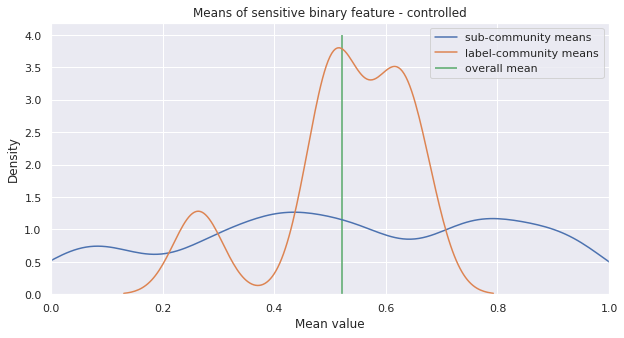

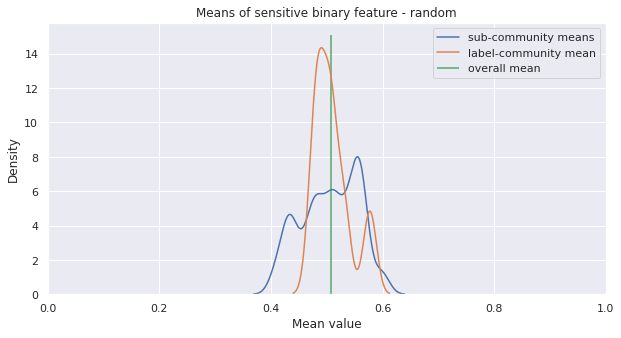

In [22]:
def plot_means_sensitive(label_df):
    """Plots the means of the sensitive feature for the controlled and for the 
    random assignment for the sub-communties and the label-communities.

    Parameters
    ----------
    label_df : pd.DataFrame
        Contains the assigned community and the sensitive feature
    """

    sns.set(rc={'figure.figsize':(10, 5)})

    sns.kdeplot(label_df.groupby("start_comms")["sensitive_controlled"].mean().values, label="sub-community means", bw_adjust=0.5)
    sns.kdeplot(label_df.groupby("comb_comms")["sensitive_controlled"].mean().values, label="label-community means", bw_adjust=0.5)
    plt.vlines(label_df["sensitive_controlled"].mean(), 0, plt.ylim()[1], label="overall mean", color="g")
    plt.title("Means of sensitive binary feature - controlled")
    plt.legend()
    plt.xlabel("Mean value")
    plt.xlim(0,1)
    plt.show()

    sns.kdeplot(label_df.groupby("start_comms")["sensitive_random"].mean().values, label="sub-community means", bw_adjust=0.5)
    sns.kdeplot(label_df.groupby("comb_comms")["sensitive_random"].mean().values, label="label-community mean", bw_adjust=0.5)
    plt.vlines(label_df["sensitive_random"].mean(), 0, plt.ylim()[1], label="overall mean", color="g")
    plt.title("Means of sensitive binary feature - random")
    plt.legend()
    plt.xlabel("Mean value")
    plt.xlim(0,1)
    plt.show()

plot_means_sensitive(label_df)

### Gain Comparison: GNN vs. MLP with different features

"controlled gain to randomized" shows the improvement of the controlled feature to the random feature.

The gain between the MLP and GNNs seems to be very similar.

In [12]:
eval_res = evaluate_sensitive_feature(iterations=30, sensitive_bias=0, feature_cov=1)

display(compute_metrics_over_iterations(eval_res))
display(compute_gains(eval_res))

100%|██████████| 30/30 [32:30<00:00, 65.02s/it]


,Mean sensitive controlled,Mean sensitive random
GCN Acc,0.65 (+/- 0.04),0.63 (+/- 0.05)
GAT Acc,0.56 (+/- 0.07),0.53 (+/- 0.07)
GraphSAGE Acc,0.63 (+/- 0.06),0.59 (+/- 0.06)
SGC Acc,0.53 (+/- 0.09),0.5 (+/- 0.08)
H2GCN Acc,0.54 (+/- 0.04),0.5 (+/- 0.04)
MLP Acc,0.47 (+/- 0.05),0.43 (+/- 0.04)
Number of edges,5982.5 (+/- 229.33),5982.5 (+/- 229.33)
Number of nodes,2708.0 (+/- 0.0),2708.0 (+/- 0.0)
Number of features,6.0 (+/- 0.0),6.0 (+/- 0.0)
Homophily edge ratio,0.78 (+/- 0.01),0.78 (+/- 0.01)


,controlled gain to randomised
GCN Acc,"2.4 (+/- 2.58), p=0.0"
GAT Acc,"3.09 (+/- 3.52), p=0.0"
GraphSAGE Acc,"4.02 (+/- 4.76), p=0.0"
SGC Acc,"3.28 (+/- 2.66), p=0.0"
H2GCN Acc,"4.11 (+/- 2.1), p=0.0"
MLP Acc,"3.71 (+/- 2.14), p=0.0"


#### Hypothesis
Gains from adding the controlled sensitive variable for the MLP are similar to gains of GCN because the baseline accuracy of the MLP is lower.
The GNNs should utilize the sensitive feature better than the MLP, as the distributions of the sensitive feature are different for each sub-community, but similar for each label-community. This should give the GNN additional structural information.

#### Experiment
By increasing the variance when creating the features, the base accuracy of the GCN decreases. Therefore we compute the gain of different variance values. We then compare the gains of GCN and MLP for similar base accuracies.

In [13]:
feature_variances = [2**i for i in range(-1, 4)]

combined_eval_res = []
for variance in feature_variances:
    combined_eval_res += evaluate_sensitive_feature(iterations=10, sensitive_bias=0, feature_cov=variance)

100%|██████████| 10/10 [09:47<00:00, 58.77s/it]


In the scatterplot of random base-accuracy vs. gains for GCN and MLP we can see that the GCN gains seem to be slightly bigger than the MLP gains (Here only the random accuracies where MLP and GCN overlap are used).

This could be a hint that the GCN can utilize the sensitive feature more efficient, but more experiments are needed.

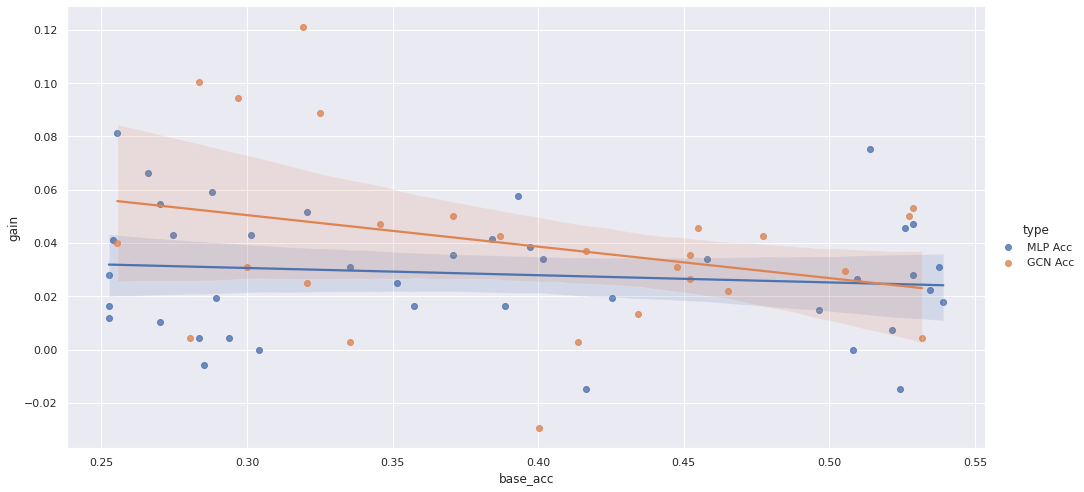

In [20]:
control_col = "LFR Cora - sensitive controlled"
random_col = "LFR Cora - sensitive random"
acc_cols = ["GCN Acc", "MLP Acc"]

# bring results in correct for plotting
gain_dfs = []
for df in combined_eval_res:
    control_gain = pd.DataFrame(df[control_col][acc_cols] - df[random_col][acc_cols]).T.astype(float)
    base_accs = pd.DataFrame(df[random_col][acc_cols]).T.astype(float)
    control_gain.columns = control_gain.columns + "_gain"
    gain_df = pd.concat([
        control_gain.melt(var_name="gain_type", value_name="gain"), 
        base_accs.melt(var_name="type", value_name="base_acc")], 
        axis=1).drop("gain_type", axis=1)
    gain_dfs.append(gain_df)

scatter_data = pd.concat(gain_dfs).reset_index(drop=True)

sns.lmplot(
    data=scatter_data.query("base_acc > 0.25 and base_acc < 0.55"), 
    x="base_acc", 
    y="gain", 
    hue="type", 
    height=7, 
    aspect=2
)

### Possible Problem: Information Leakage

Due to the relativly small number of sub-communities there is still information between the controlled sensitive feature and the label, which is probably the reason the MLP gains are close to the GCN gains.

#### RMI
RMI between random/controlled sensitive variable and sub-/label communities.

In [15]:
# get sensitive variable from features
sensitive_variable_controlled = reduced_data_sensitive_controlled.x[:, -1]
sensitive_variable_random = reduced_data_sensitive_random.x[:, -1]

# calculate RMI with sensitive variable as "found" community and Sub-/Label communities as label
print(f"RMI Sub-Communities - controlled sensitive: {calc_uncertainty(found_data, sensitive_variable_controlled):.3f}")
print(f"RMI Sub-Communities - random sensitive: {calc_uncertainty(found_data, sensitive_variable_random):.3f}")
print()
print(f"RMI Label-Communities - controlled sensitive: {calc_uncertainty(reduced_found_data, sensitive_variable_controlled):.3f}")
print(f"RMI Label-Communities - random sensitive: {calc_uncertainty(reduced_found_data, sensitive_variable_random):.3f}")

RMI Sub-Communities - controlled sensitive: 0.033
RMI Sub-Communities - random sensitive: 0.001

RMI Label-Communities - controlled sensitive: 0.019
RMI Label-Communities - random sensitive: 0.001


#### Chi-squared test

p-value for the hypothesis test of independence of the observed frequencies in the contingency table

*   With sub-communties: <br/>
    Dependece of controlled feature to sub-communities is expected

*   With label-communties: <br/>
    Optimally no dependence between controlled feature and label-communities should occur



In [16]:
# https://machinelearningmastery.com/chi-squared-test-for-machine-learning/
def chi_square(df):
    table = df.pivot_table(index="sensitive_var", columns="label", aggfunc=len).astype(int)
    stat, p, dof, expected = chi2_contingency(table)
    return p

print("Sub-Communities")
print(f"Chi-squared test with random feature {chi_square(pd.DataFrame({'label': found_data.y, 'sensitive_var': sensitive_variable_random})):.2f} -> independent")
print(f"Chi-squared test with controlled feature {chi_square(pd.DataFrame({'label': found_data.y, 'sensitive_var': sensitive_variable_controlled})):.2f} -> dependend")
print()
print("Label-Communities")
print(f"Chi-squared test with random feature {chi_square(pd.DataFrame({'label': reduced_found_data.y, 'sensitive_var': sensitive_variable_random})):.2f} -> independent")
print(f"Chi-squared test with controlled feature {chi_square(pd.DataFrame({'label': reduced_found_data.y, 'sensitive_var': sensitive_variable_controlled})):.2f} -> dependend")

Sub-Communities
Chi-squared test with random feature 0.47 -> independent
Chi-squared test with controlled feature 0.00 -> dependend

Label-Communities
Chi-squared test with random feature 0.14 -> independent
Chi-squared test with controlled feature 0.00 -> dependend


# Possible next steps

* Re-evaluate gains of GCN vs. MLP by constructing more sub-communities in order to make the label-communities and the sensitive features independent and test with more iterations.
* Evaluate correlation of gains between GNN vs. MLP compared to RMI and homophily metrics.
* Fine-Tuning of ML models.
* Compare GNN models on mixed graph consisting of several LFR graphs vs. single graphs.